# Lecture 18: Robust nonlinear solvers

> Given a continuous function $f(x)$, the problem is to find a point $x^*$ such that $f(x^*) = 0$. That is, $x^*$ is a solution of the equation $f(x) = 0$ and is called a **root of $f(x)$**.

## Summary so far

|                    | Bisection         | Newton's method            | Modified Newton   | Secant            |
|--------------------|-------------------|----------------------------|-------------------|-------------------|
| Simple algorithm   | yes               | yes                        | yes               | yes               |
| Starting values    | bracket           | one                        | one               | two               |
| Iterations         | lots              | normally fewer             | similar to Newton | similar to Newton |
| Function evals     | one per iteration | `f` and `df` per iteration | two per iteration | one per iteration |
| Convergence        | with good bracket | **not always**             | **not always**    | **not always**    |
| Turing point roots | no                | slower                     | slower            | slower            |
| Use of derivative  | no                | yes                        | no                | no                |

## The big idea

Combine the robustness of the bisection but improve the estimate using the secant method.

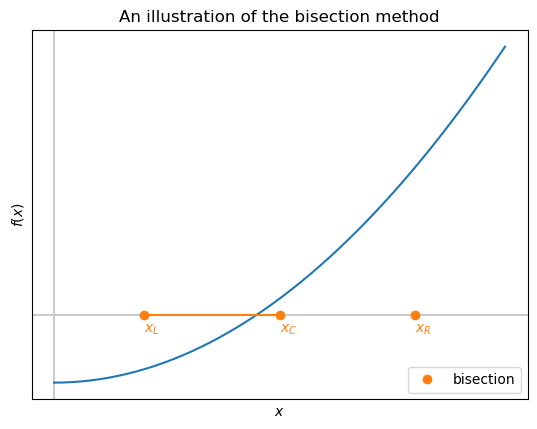

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.axhline(0, color="0.8")  # x = 0
plt.axvline(0, color="0.8")  # y = 0

f = lambda t: t**2 - 0.2
df = lambda t: 2 * t

x = np.linspace(0, 1)
y = f(x)

plt.plot(x, y)

xL = 0.2
xR = 0.8

l = plt.plot([xL, (xL + xR) / 2, xR], [0.0, 0, 0.0], "o", label="bisection")
plt.plot([xL, (xL + xR) / 2], [0.0, 0.0], color=l[0].get_color())
plt.text(xL, -0.05, "$x_L$", color=l[0].get_color())
plt.text((xL + xR) / 2, -0.05, "$x_C$", color=l[0].get_color())
plt.text(xR, -0.05, "$x_R$", color=l[0].get_color())

plt.title("An illustration of the bisection method")
plt.xticks([])
plt.yticks([])
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

plt.legend()
plt.show()

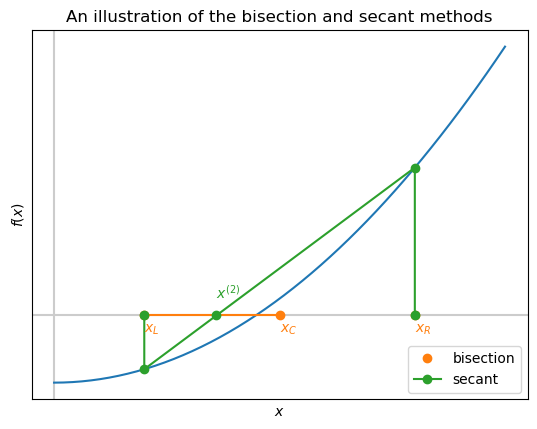

In [2]:
plt.axhline(0, color="0.8")  # x = 0
plt.axvline(0, color="0.8")  # y = 0

f = lambda t: t**2 - 0.2
df = lambda t: 2 * t

x = np.linspace(0, 1)
y = f(x)

plt.plot(x, y)

xL = 0.2
xR = 0.8

l = plt.plot([xL, (xL + xR) / 2, xR], [0.0, 0, 0.0], "o", label="bisection")
plt.plot([xL, (xL + xR) / 2], [0.0, 0.0], color=l[0].get_color())
plt.text(xL, -0.05, "$x_L$", color=l[0].get_color())
plt.text((xL + xR) / 2, -0.05, "$x_C$", color=l[0].get_color())
plt.text(xR, -0.05, "$x_R$", color=l[0].get_color())

xnew = xR - f(xR) * (xR - xL) / (f(xR) - f(xL))
l = plt.plot([xL, xL, xnew, xR, xR], [0.0, f(xL), 0.0, f(xR), 0], "o-", label="secant")
plt.text(xnew, +0.05, "$x^{(2)}$", color=l[0].get_color())

plt.title("An illustration of the bisection and secant methods")
plt.xticks([])
plt.yticks([])
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

plt.legend()
plt.show()

The bisection method doesn't use the values of $f$ only it's sign. Use this to improve the convergence rate.

## False position method (regula falisi)

The idea is to take the bisection method but instead of evaluating f and the midpoint of $(x_L, x_R)$ and computing signs, we evaluate at the point obtained from the application of the secant method to $x_L, x_R$:

In [3]:
def false_position(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)
    fc = tol + 1

    while b - a > tol and abs(fc) > tol:
        # Find new point **using secant method**
        c = b - fb * (b - a) / (fb - fa)
        fc = func(c)

        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc

    return c

In [4]:
import pandas as pd


def false_position(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)
    fc = tol + 1

    it = 0
    headers = ["it", "a", "f(a)", "b", "f(b)", "c", "f(c)"]
    data = [[it, a, fa, b, fb]]

    while b - a > tol and abs(fc) > tol:
        # Find new point **using secant method**
        c = b - fb * (b - a) / (fb - fa)
        fc = func(c)

        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc

        it = it + 1
        data.append([it, a, fa, b, fb, c, fc])

    df = pd.DataFrame(data, columns=headers)
    return df.style.hide_index().set_na_rep("--")

## Example

A simply example $f(x) = x^2 - 2$ starting from bracket $(1, 2)$.

*What happens to the right end of the bracket?*

In [5]:
def f(x):
    return x * x - 2.0


false_position(f, 1.0, 2.0, tol=1.0e-4)

it,a,f(a),b,f(b),c,f(c)
0,1.000000,-1.000000,2.000000,2.000000,--,--
1,1.333333,-0.222222,2.000000,2.000000,1.333333,-0.222222
2,1.400000,-0.040000,2.000000,2.000000,1.400000,-0.040000
3,1.411765,-0.006920,2.000000,2.000000,1.411765,-0.006920
4,1.413793,-0.001189,2.000000,2.000000,1.413793,-0.001189
5,1.414141,-0.000204,2.000000,2.000000,1.414141,-0.000204
6,1.414201,-0.000035,2.000000,2.000000,1.414201,-0.000035


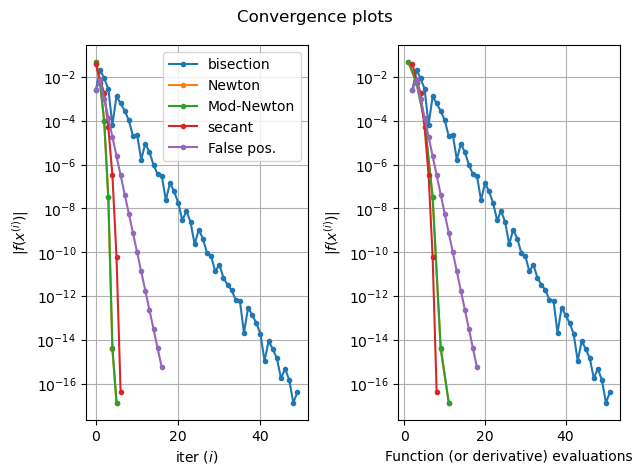

In [6]:
def f(x):
    t = 0.1

    yp = (
        -0.1015 * np.power(x, 4)
        + 0.2843 * np.power(x, 3)
        - 0.3516 * np.power(x, 2)
        - 0.126 * x
        + 0.2969 * np.sqrt(x)
    )
    f = yp - 0.5 * t

    return f


def df(x):
    dy = (
        -4 * 0.1015 * np.power(x, 3)
        + 3 * 0.2843 * np.power(x, 2)
        - 2 * 0.3516 * x
        - 0.126
        + 0.2969 * 0.5 * np.power(x, -0.5)
    )
    f = dy

    return f


def bisection(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)

    feval = [2]
    rets = [(a + b) / 2]

    while b - a > tol:
        # Find new mid point
        c = (a + b) / 2
        fc = func(c)

        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc

        feval.append(feval[-1] + 1)
        rets.append((a + b) / 2)

    return rets, feval


def newton(f, df, x0, tol=1.0e-10):
    x = x0

    feval = [1]
    rets = [x]

    while abs(f(x)) > tol:
        x = x - f(x) / df(x)
        rets.append(x)
        feval.append(feval[-1] + 2)

    return rets, feval


def modified_newton(f, x0, tol=1.0e-10, maxiter=100):
    eps = np.finfo(np.double).eps
    dx = np.sqrt(eps)

    x = x0
    rets = [x]
    feval = [1]

    while abs(f(x)) > tol:

        df = (f(x + dx) - f(x)) / dx
        x = x - f(x) / df

        rets.append(x)
        feval.append(feval[-1] + 2)

    return rets, feval


def secant(f, x0, x1, tol=1.0e-10):
    # two initial function evaluations
    f0 = f(x0)
    f1 = f(x1)

    feval = [2]
    rets = [x1]

    while abs(f1) > tol:
        # compute derivative approximation
        df = (f1 - f0) / (x1 - x0)
        # update x
        x2 = x1 - f1 / df

        # update other variables
        x0, f0 = x1, f1
        x1, f1 = x2, f(x2)  # one evaluation of f per iteration

        rets.append(x1)
        feval.append(feval[-1] + 1)

    return rets, feval


def false_position(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)
    fc = 2 * tol

    feval = [2]
    rets = [(a + b) / 2]

    while b - a > tol and abs(fc) > tol:
        # Find new mid point
        c = b - fb * (b - a) / (fb - fa)
        fc = func(c)

        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc

        feval.append(feval[-1] + 1)
        rets.append(c)

    return rets, feval


tol = 1.0e-15
bisection_rets, bisection_fevals = bisection(f, 0.5, 1.0, tol=tol)
newton_rets, newton_fevals = newton(f, df, x0=1.0, tol=tol)
modified_rets, modified_fevals = modified_newton(f, x0=1.0, tol=tol)
secant_rets, secant_fevals = secant(f, x0=1.0, x1=0.5, tol=tol)
false_rets, false_fevals = false_position(f, 0.5, 1.0, tol=tol)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Convergence plots")

ax1.semilogy([abs(f(x)) for x in bisection_rets], ".-", label="bisection")
ax1.semilogy([abs(f(x)) for x in newton_rets], ".-", label="Newton")
ax1.semilogy([abs(f(x)) for x in modified_rets], ".-", label="Mod-Newton")
ax1.semilogy([abs(f(x)) for x in secant_rets], ".-", label="secant")
ax1.semilogy([abs(f(x)) for x in false_rets], ".-", label="False pos.")

ax1.set_xlabel("iter ($i$)")
ax1.set_ylabel("$|f(x^{(i)})|$")
ax1.grid()
ax1.legend()

ax2.semilogy(
    bisection_fevals, [abs(f(x)) for x in bisection_rets], ".-", label="bisection"
)
ax2.semilogy(newton_fevals, [abs(f(x)) for x in newton_rets], ".-", label="Newton")
ax2.semilogy(
    modified_fevals, [abs(f(x)) for x in modified_rets], ".-", label="Mod-Newton"
)
ax2.semilogy(secant_fevals, [abs(f(x)) for x in secant_rets], ".-", label="secant")
ax2.semilogy(false_fevals, [abs(f(x)) for x in false_rets], ".-", label="False pos.")

ax2.set_xlabel("Function (or derivative) evaluations")
ax2.set_ylabel("$|f(x^{(i)})|$")
ax2.grid()

plt.tight_layout()
plt.show()

# Dekker's method

This is a another hybrid method that combines the bisection and secant method.

We find two candidates for approximating the root - given by the secant method and by the bisection method. $b$ becomes the new estimate of the root and $a$ is updated to maintain the bracket.

The function requires both an initial bracket:

```python
def dekker(func, a, b, tol=1.0e-10): 
    assert func(a) * func(b) < 0 # ensure we have a bracket
    c = a                        # start old b at a
    assert abs(b - c) > tol      # ensure we have b != c
```

In [7]:
def dekker(func, a, b, tol=1.0e-10):
    # start at old b at a
    c = a

    while abs(f(b)) > tol:
        # generate two possible estimates
        m = midpoint_update(func, a, b)
        try:
            s = secant_update(func, b, c)
        except ZeroDivisionError:
            s = m

        # choose best b and update c
        b, c = update_b(b, s, m), b

        # choose a to form a bracket
        a = update_a(func, a, b, c)

        # choose best value for iteration from a and b
        a, b = best_ab(func, a, b)

    return b

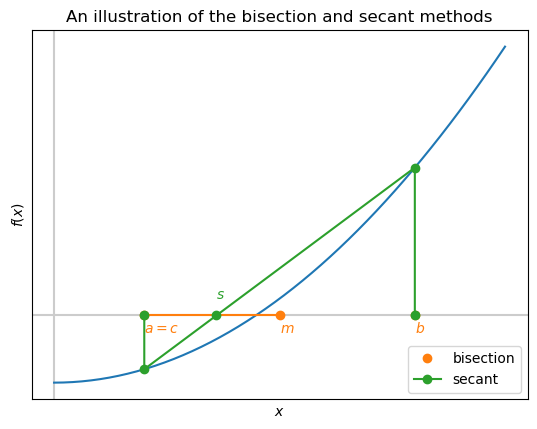

In [8]:
plt.axhline(0, color="0.8")  # x = 0
plt.axvline(0, color="0.8")  # y = 0

f = lambda t: t**2 - 0.2
df = lambda t: 2 * t

x = np.linspace(0, 1)
y = f(x)

plt.plot(x, y)

xL = 0.2
xR = 0.8

l = plt.plot([xL, (xL + xR) / 2, xR], [0.0, 0, 0.0], "o", label="bisection")
plt.plot([xL, (xL + xR) / 2], [0.0, 0.0], color=l[0].get_color())
plt.text(xL, -0.05, "$a = c$", color=l[0].get_color())
plt.text((xL + xR) / 2, -0.05, "$m$", color=l[0].get_color())
plt.text(xR, -0.05, "$b$", color=l[0].get_color())

xnew = xR - f(xR) * (xR - xL) / (f(xR) - f(xL))
l = plt.plot([xL, xL, xnew, xR, xR], [0.0, f(xL), 0.0, f(xR), 0], "o-", label="secant")
plt.text(xnew, +0.05, "$s$", color=l[0].get_color())

plt.title("An illustration of the bisection and secant methods")
plt.xticks([])
plt.yticks([])
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

plt.legend()
plt.show()

In [9]:
def secant_update(func, x, xn):
    return x - func(x) * (x - xn) / (func(x) - func(xn))


def midpoint_update(func, xL, xR):
    return (xL + xR) / 2

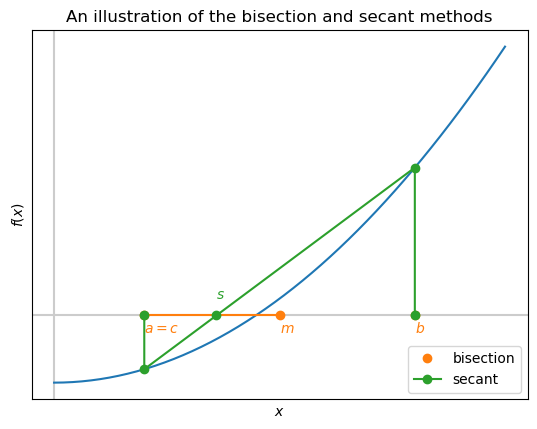

In [10]:
plt.axhline(0, color="0.8")  # x = 0
plt.axvline(0, color="0.8")  # y = 0

f = lambda t: t**2 - 0.2
df = lambda t: 2 * t

x = np.linspace(0, 1)
y = f(x)

plt.plot(x, y)

xL = 0.2
xR = 0.8

l = plt.plot([xL, (xL + xR) / 2, xR], [0.0, 0, 0.0], "o", label="bisection")
plt.plot([xL, (xL + xR) / 2], [0.0, 0.0], color=l[0].get_color())
plt.text(xL, -0.05, "$a = c$", color=l[0].get_color())
plt.text((xL + xR) / 2, -0.05, "$m$", color=l[0].get_color())
plt.text(xR, -0.05, "$b$", color=l[0].get_color())

xnew = xR - f(xR) * (xR - xL) / (f(xR) - f(xL))
l = plt.plot([xL, xL, xnew, xR, xR], [0.0, f(xL), 0.0, f(xR), 0], "o-", label="secant")
plt.text(xnew, +0.05, "$s$", color=l[0].get_color())

plt.title("An illustration of the bisection and secant methods")
plt.xticks([])
plt.yticks([])
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

plt.legend()
plt.show()

In [11]:
def update_b(b, s, m):
    # if s lies strictly between m and b
    if (m < s and s < b) or (b < s and s < m):
        # b <- s (secant)
        return s
    else:
        # b <- m (midpoint)
        return m

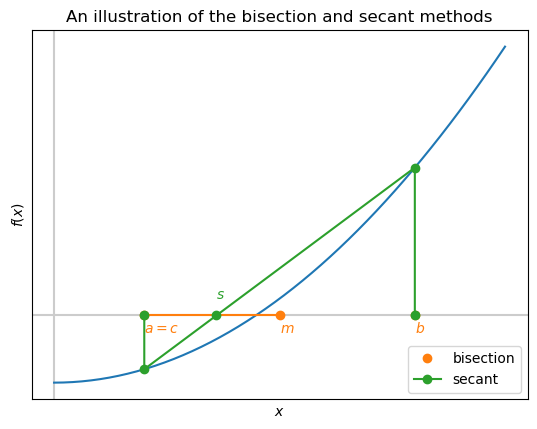

In [12]:
plt.axhline(0, color="0.8")  # x = 0
plt.axvline(0, color="0.8")  # y = 0

f = lambda t: t**2 - 0.2
df = lambda t: 2 * t

x = np.linspace(0, 1)
y = f(x)

plt.plot(x, y)

xL = 0.2
xR = 0.8

l = plt.plot([xL, (xL + xR) / 2, xR], [0.0, 0, 0.0], "o", label="bisection")
plt.plot([xL, (xL + xR) / 2], [0.0, 0.0], color=l[0].get_color())
plt.text(xL, -0.05, "$a = c$", color=l[0].get_color())
plt.text((xL + xR) / 2, -0.05, "$m$", color=l[0].get_color())
plt.text(xR, -0.05, "$b$", color=l[0].get_color())

xnew = xR - f(xR) * (xR - xL) / (f(xR) - f(xL))
l = plt.plot([xL, xL, xnew, xR, xR], [0.0, f(xL), 0.0, f(xR), 0], "o-", label="secant")
plt.text(xnew, +0.05, "$s$", color=l[0].get_color())

plt.title("An illustration of the bisection and secant methods")
plt.xticks([])
plt.yticks([])
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

plt.legend()
plt.show()

In [13]:
def update_a(func, a, b, c):
    # set a to be either a or c so that f(a)*f(b) < 0
    if func(a) * func(b) < 0:
        # (a, b) form a bracket: a <- a
        return a
    elif func(c) * func(b) < 0:
        # (c, b) form a bracket: a <- c
        return c
    else:
        raise Exception("No bracket found")

In [14]:
def best_ab(func, a, b):
    # if a is better estimate
    if abs(func(a)) < abs(func(b)):
        # swap!
        return b, a
    else:
        # don't swap!
        return a, b

## Examples

A simply example $f(x) = x^2 - 2$ starting from bracket $(1, 2)$

*What happens to the left end of the bracket?*

In [15]:
def update_b(b, s, m):
    # if s lies between m and bn
    if (m < s < b) or (b <= s <= m):
        # b <- s
        return "secant", s
    else:
        # b <- m
        return "midpoint", m


def dekker(func, a, b, tol=1.0e-10):
    c = a  # c is previous value of b
    it = 0

    headers = ["it", "a", "f(a)", "b", "f(b)", "update"]
    data = [[it, a, func(a), b, func(b)]]

    while abs(f(b)) > tol:
        it += 1

        # generate two possible estimates
        m = midpoint_update(func, a, b)
        try:
            s = secant_update(func, b, c)
        except ZeroDivisionError:
            s = m

        # choose best b and update bn
        (update, b), c = update_b(b, s, m), b

        # choose a to form a bracket
        a = update_a(func, a, b, c)

        # choose best value for iteration from a and b
        a, b = best_ab(func, a, b)

        data.append([it, a, func(a), b, func(b), update])

        if it > 50:
            break

    df = pd.DataFrame(data, columns=headers)
    return df.style.hide_index()

In [16]:
def f(x):
    return x * x - 2


dekker(f, a=1.0, b=2.0, tol=1.0e-4)

it,a,f(a),b,f(b),update
0,1.000000,-1.000000,2.000000,2.000000,None
1,1.000000,-1.000000,1.500000,0.250000,midpoint
2,1.000000,-1.000000,1.428571,0.040816,secant
3,1.000000,-1.000000,1.414634,0.001190,secant
4,1.000000,-1.000000,1.414216,0.000006,secant


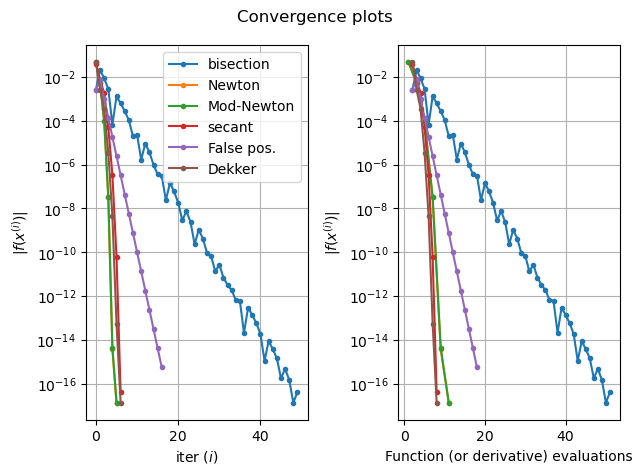

In [17]:
def f(x):
    t = 0.1

    yp = (
        -0.1015 * np.power(x, 4)
        + 0.2843 * np.power(x, 3)
        - 0.3516 * np.power(x, 2)
        - 0.126 * x
        + 0.2969 * np.sqrt(x)
    )
    f = yp - 0.5 * t

    return f


def df(x):
    dy = (
        -4 * 0.1015 * np.power(x, 3)
        + 3 * 0.2843 * np.power(x, 2)
        - 2 * 0.3516 * x
        - 0.126
        + 0.2969 * 0.5 * np.power(x, -0.5)
    )
    f = dy

    return f


def bisection(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)

    feval = [2]
    rets = [(a + b) / 2]

    while b - a > tol:
        # Find new mid point
        c = (a + b) / 2
        fc = func(c)

        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc

        feval.append(feval[-1] + 1)
        rets.append((a + b) / 2)

    return rets, feval


def newton(f, df, x0, tol=1.0e-10):
    x = x0

    feval = [1]
    rets = [x]

    while abs(f(x)) > tol:
        x = x - f(x) / df(x)
        rets.append(x)
        feval.append(feval[-1] + 2)

    return rets, feval


def modified_newton(f, x0, tol=1.0e-10, maxiter=100):
    eps = np.finfo(np.double).eps
    dx = np.sqrt(eps)

    x = x0
    rets = [x]
    feval = [1]

    while abs(f(x)) > tol:

        df = (f(x + dx) - f(x)) / dx
        x = x - f(x) / df

        rets.append(x)
        feval.append(feval[-1] + 2)

    return rets, feval


def secant(f, x0, x1, tol=1.0e-10):
    # two initial function evaluations
    f0 = f(x0)
    f1 = f(x1)

    feval = [2]
    rets = [x1]

    while abs(f1) > tol:
        # compute derivative approximation
        df = (f1 - f0) / (x1 - x0)
        # update x
        x2 = x1 - f1 / df

        # update other variables
        x0, f0 = x1, f1
        x1, f1 = x2, f(x2)  # one evaluation of f per iteration

        rets.append(x1)
        feval.append(feval[-1] + 1)

    return rets, feval


def false_position(func, a, b, tol=1.0e-10):
    # Starting values
    fa = func(a)
    fb = func(b)
    fc = 2 * tol

    feval = [2]
    rets = [(a + b) / 2]

    while b - a > tol and abs(fc) > tol:
        # Find new mid point
        c = b - fb * (b - a) / (fb - fa)
        fc = func(c)

        # if root is in left half of interval
        if fa * fc < 0.0:
            # move right end
            b = c
            fb = fc
        else:
            # otherwise,
            # move the left end
            a = c
            fa = fc

        feval.append(feval[-1] + 1)
        rets.append(c)

    return rets, feval


def dekker(func, a, b, tol=1.0e-10):
    rets = [b]
    fevals = [2]

    # start at old b at a
    bn = a

    while abs(f(b)) > tol:
        # generate two possible estimates
        m = midpoint_update(func, a, b)
        try:
            s = secant_update(func, b, bn)
        except ZeroDivisionError:
            s = m

        # choose best b and update bn
        (update, b), bn = update_b(b, s, m), b

        # choose a to form a bracket
        a = update_a(func, a, b, bn)

        # choose best value for iteration from a and b
        a, b = best_ab(func, a, b)

        rets.append(b)
        fevals.append(fevals[-1] + 1)

    return rets, fevals


tol = 1.0e-15
bisection_rets, bisection_fevals = bisection(f, 0.5, 1.0, tol=tol)
newton_rets, newton_fevals = newton(f, df, x0=1.0, tol=tol)
modified_rets, modified_fevals = modified_newton(f, x0=1.0, tol=tol)
secant_rets, secant_fevals = secant(f, x0=1.0, x1=0.5, tol=tol)
false_rets, false_fevals = false_position(f, 0.5, 1.0, tol=tol)
dekker_rets, dekker_fevals = dekker(f, a=0.5, b=1.0, tol=tol)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Convergence plots")

ax1.semilogy([abs(f(x)) for x in bisection_rets], ".-", label="bisection")
ax1.semilogy([abs(f(x)) for x in newton_rets], ".-", label="Newton")
ax1.semilogy([abs(f(x)) for x in modified_rets], ".-", label="Mod-Newton")
ax1.semilogy([abs(f(x)) for x in secant_rets], ".-", label="secant")
ax1.semilogy([abs(f(x)) for x in false_rets], ".-", label="False pos.")
ax1.semilogy([abs(f(x)) for x in dekker_rets], ".-", label="Dekker")

ax1.set_xlabel("iter ($i$)")
ax1.set_ylabel("$|f(x^{(i)})|$")
ax1.grid()
ax1.legend()

ax2.semilogy(
    bisection_fevals, [abs(f(x)) for x in bisection_rets], ".-", label="bisection"
)
ax2.semilogy(newton_fevals, [abs(f(x)) for x in newton_rets], ".-", label="Newton")
ax2.semilogy(
    modified_fevals, [abs(f(x)) for x in modified_rets], ".-", label="Mod-Newton"
)
ax2.semilogy(secant_fevals, [abs(f(x)) for x in secant_rets], ".-", label="secant")
ax2.semilogy(false_fevals, [abs(f(x)) for x in false_rets], ".-", label="False pos.")
ax2.semilogy(dekker_fevals, [abs(f(x)) for x in dekker_rets], ".-", label="Dekker")

ax2.set_xlabel("Function (or derivative) evaluations")
ax2.set_ylabel("$|f(x^{(i)})|$")
ax2.grid()

plt.tight_layout()
plt.show()

## Summary 

|                    | Bisection         | Newton's method            | Modified Newton   | Secant            | False position    | Dekker            |
|--------------------|-------------------|----------------------------|-------------------|-------------------|-------------------|-------------------|
| Simple algorithm   | yes               | yes                        | yes               | yes               | yes               | more complicated  |
| Starting values    | bracket           | one                        | one               | two               | bracket           | bracket     |
| Iterations         | lots              | normally fewer             | similar to Newton | similar to Newton | middle            | similar to Newton |
| Function evals     | one per iteration | `f` and `df` per iteration | two per iteration | one per iteration | one per iteration | one per iteration |
| Convergence        | with good bracket | not always                 | not always        | not always        | with good bracket | with good bracket |
| Turing point roots | no                | slower                     | slower            | slower            | no                | no                |
| Use of derivative  | no                | yes                        | no                | no                | no                | no                |